In [14]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm

In [15]:
insurance_df = pd.read_csv("../Data/insurance.csv")
insurance_df.head()


age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

## Exploratory Data Analysis
- Visualize features

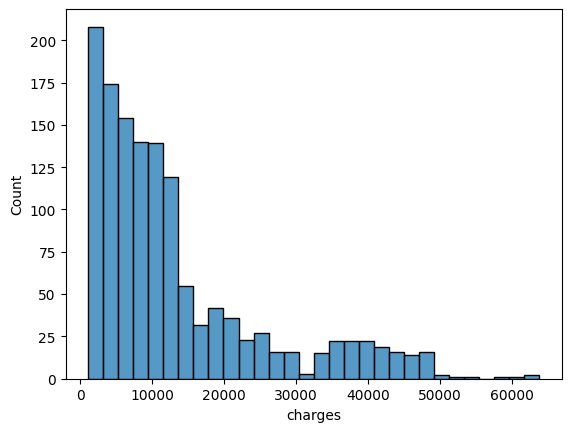

In [3]:
sns.histplot(insurance_df["charges"]);

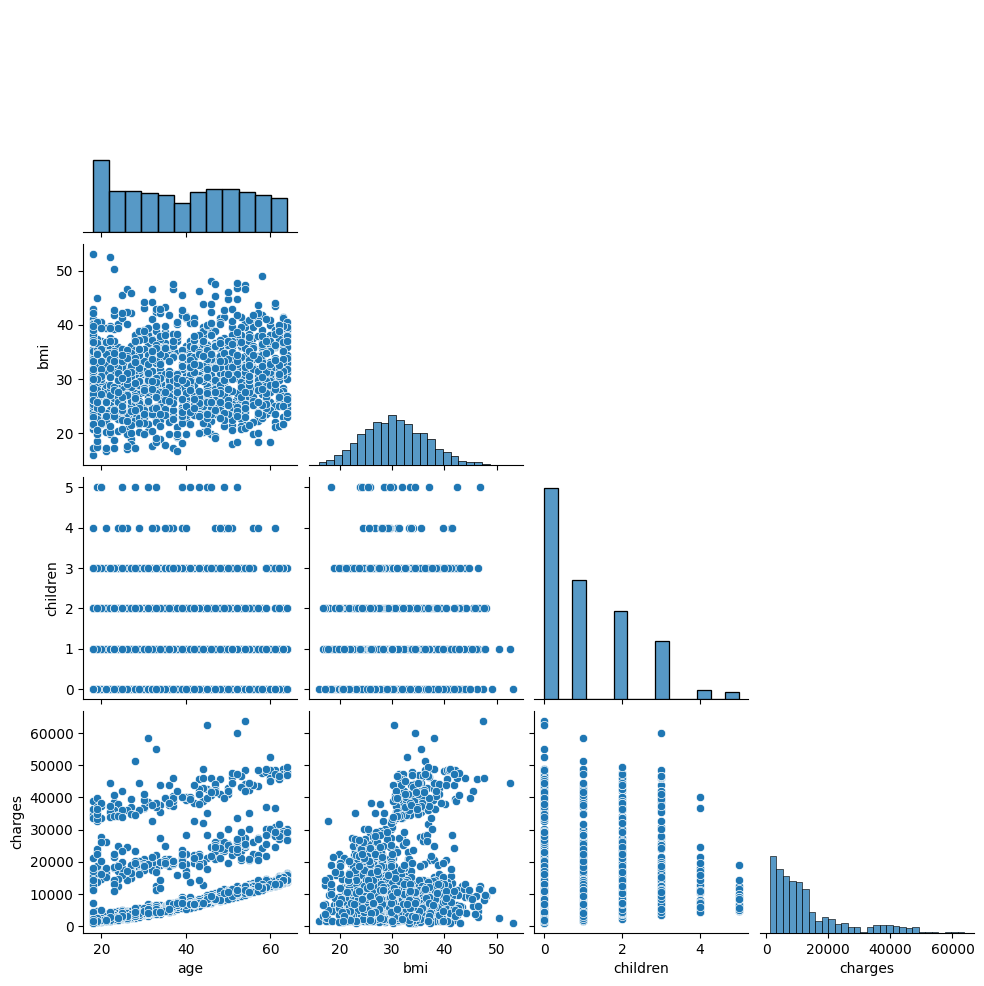

In [16]:
# Look for patterns for features vs target and feature vs feature
sns.pairplot(insurance_df, corner=True);
# There seems to be a positive relationship between age and charges but shows three levels.
# Shows positive relationship between charges and bmi


In [6]:
# Check correlation
# age shows the strongest correlation against the charges 0.299
insurance_df.corr(numeric_only=True)

age       bmi  children   charges
age       1.000000  0.109272  0.042469  0.299008
bmi       0.109272  1.000000  0.012759  0.198341
children  0.042469  0.012759  1.000000  0.067998
charges   0.299008  0.198341  0.067998  1.000000

### Fitting the Model

In [7]:
X = sm.add_constant(insurance_df["age"]) # Add constant
y = insurance_df["charges"]

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     131.2
Date:                Mon, 03 Mar 2025   Prob (F-statistic):           4.89e-29
Time:                        23:47:50   Log-Likelihood:                -14415.
No. Observations:                1338   AIC:                         2.883e+04
Df Residuals:                    1336   BIC:                         2.884e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3165.8850    937.149      3.378      0.001    1327.440    5004.330
age          257.7226     22.502     11.453      0.000     213.579     301.866
==============================================================================
Omnibus:                      399.600   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              864.239
Skew:                           1.733   Prob(JB):                    2.15e-188
Kurtosis:                       4.869   Cond. No.                         124.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Making Predictions

In [8]:
customer_ages = [18, 25, 35, 45, 55]

X_predict = sm.add_constant(pd.DataFrame({"age": customer_ages}))

X_predict

const  age
0    1.0   18
1    1.0   25
2    1.0   35
3    1.0   45
4    1.0   55

In [12]:
model.predict(X_predict)

0     7804.892142
1     9608.950473
2    12186.176659
3    14763.402846
4    17340.629033
dtype: float64

In [10]:
predictions = model.predict(X_predict)

predictions.name = "predictions"

In [11]:
## Compare predictions to actual values

(insurance_df
 .query("age in @customer_ages")
 .groupby("age")
 .agg({"charges": "mean"})
 .reset_index()
 .merge(predictions, left_index=True, right_index=True)
 .assign(
     error = lambda x: x["predictions"] - x["charges"],
     pct_difference = lambda x: (x["error"] / x["charges"]) * 100
 
 )
)

age       charges   predictions        error  pct_difference
0   18   7086.217556   7804.892142   718.674586       10.141865
1   25   9838.365311   9608.950473  -229.414838       -2.331839
2   35  11307.182031  12186.176659   878.994628        7.773773
3   45  14830.199856  14763.402846   -66.797010       -0.450412
4   55  16164.545488  17340.629033  1176.083544        7.275698

<Axes: ylabel='None'>

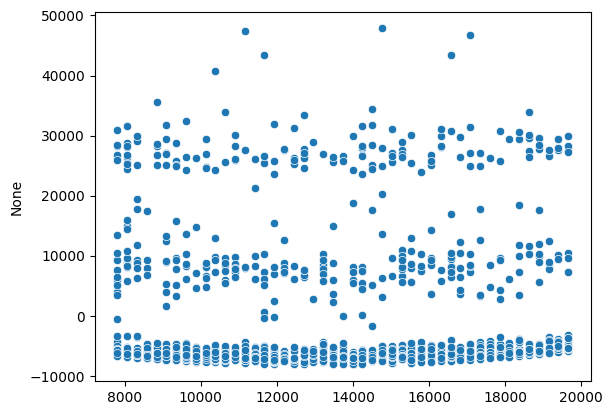

In [13]:
# Plot Residuals -- three tiers here to try to predict with new features

sns.scatterplot(x=model.predict(), y=model.resid)